# Assignment 1, problem 5
Nicholai L'Esperance

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
from matplotlib import pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

## Part 1: LDA

Read in the data, and set the column names.

In [2]:
data = pd.read_csv('iris.data', header=None)
data.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']

data.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
X = data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
y = data['class']

Before we scale, we must split into train and test. Scale after splitting, as to not contaiminate our test data.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [5]:
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

Now, with our standardized data, we can perform LDA. First, we calculate the mean vector for each class.

In [7]:
mu_vectors = dict()
for classname in y_train.unique():
    idx = y_train[y_train.eq(classname)].index.tolist()
    class_data = pd.DataFrame(X_train_std)
    class_data.index = y_train.index
    class_data = class_data.loc[idx]
    mu_vectors[classname] = class_data.mean().tolist()

Now, we construct the matrices Si and then the Sw matrix

In [10]:
class_scatters = list()
for classname in y_train.unique():
    idx = y_train[y_train.eq(classname)].index.tolist()
    class_data = pd.DataFrame(X_train_std)
    class_data.index = y_train.index
    class_data = class_data.loc[idx]
    
    # make a (feature x feature) zero matrix to sum into
    Si = np.zeros((class_data.shape[1], class_data.shape[1]))
    minus_mean = (class_data - mu_vectors[classname])
    for row in minus_mean.to_numpy():
        m = np.asmatrix(row)
        Si = Si + np.matmul(m.T, m)
    
    class_scatters.append(Si)

# Make our Sw matrix by summing the Si matrices
Sw = reduce(np.add, class_scatters)

In [11]:
Sw

matrix([[39.24820232, 28.26261647, 12.82341266,  7.24475977],
        [28.26261647, 70.44228744,  8.32320418, 10.83625865],
        [12.82341266,  8.32320418,  6.33214411,  3.63765772],
        [ 7.24475977, 10.83625865,  3.63765772,  7.06403019]])

Next, we calculate the Sb matrix. First, we calculate the overall mean. Because we sandardized the dataset in step one, this vector is approximately the zero vector (due to floating point errors it is slightly off).

In [12]:
mu = pd.DataFrame(X_train_std).mean().tolist()
print(mu)

[-1.249793919149462e-15, -5.075305255429287e-17, -1.4380031557049647e-16, -2.0512692074026703e-16]


In [13]:
Sb = np.zeros((X_train_std.shape[1], X_train_std.shape[1]))

for classname in y_train.unique():
    N = y_train.eq(classname).sum()
    mean_error = np.matrix(mu) - np.matrix(mu_vectors[classname])
    
    Sb = Sb + (N * mean_error.T.dot(mean_error))

Now, we compute the eigenvectors and eigenvalues of the matrix 𝑆𝑤-1 x 𝑆𝐵.

In [14]:
Sw_inv = np.linalg.inv(Sw)
SwSb = np.matmul(Sw_inv, Sb)

eigvals, eigvects = np.linalg.eig(SwSb)

Looking at our eigenvalues, they are already sorted in decreasing order. We are going to select the k=2 largest eigen values and build our transformation matrix.

In [15]:
W = eigvects[:, :2]
W

matrix([[-0.22162371+0.j,  0.04541615+0.j],
        [-0.09884496+0.j,  0.30088188+0.j],
        [ 0.88423899+0.j, -0.61837179+0.j],
        [ 0.39904136+0.j,  0.72458526+0.j]])

Note, the eig function returns everything as complex numbers. However, our data is fully real.

In [22]:
W = W.real
W

matrix([[-0.22162371,  0.04541615],
        [-0.09884496,  0.30088188],
        [ 0.88423899, -0.61837179],
        [ 0.39904136,  0.72458526]])

Finally, we can transform our standardized matrx x with four features, to a new matrix with 2 features in a new space.

In [23]:
X_train_std_lda = np.matmul(X_train_std, W)

In [24]:
X_train_std_lda[:20]

matrix([[ 0.1838912 , -0.86018258],
        [ 0.97311291, -0.04040467],
        [ 1.31245794,  0.75882824],
        [ 0.88000599, -0.72176156],
        [ 1.1825395 , -0.47577787],
        [ 0.16725416, -0.53102413],
        [ 1.22032737,  0.2813112 ],
        [ 0.45989574,  0.24378858],
        [ 0.16591758, -0.57029459],
        [ 0.79600272, -0.04971802],
        [ 0.71803798, -0.32959494],
        [ 0.94829734, -0.21501744],
        [ 0.94155357, -0.12797378],
        [ 0.20200728,  0.02537917],
        [ 0.92802945,  0.24923044],
        [ 0.41511033,  0.3655361 ],
        [-1.35879505, -0.2082886 ],
        [ 1.07276164, -0.05143096],
        [ 0.37257491, -0.31098161],
        [ 0.03216013,  0.03260119]])

### Verifying our LDA works

Now, we can try to classify using a KNN, to show that our LDA did work. We will use k=5, and compare against a KNN with untransformed scaled X data.

In [37]:
knn_lda = KNeighborsClassifier(n_neighbors=5, p=2)
knn_lda.fit(X_train_std_lda, y_train)

X_test_std_lda = np.matmul(scaler.transform(X_test), W)
lda_predict = knn_lda.predict(X_test_std_lda)

lda_percentage_correct = sum(lda_predict==y_test) / len(y_test) * 100

In [38]:
knn = KNeighborsClassifier(n_neighbors=5, p=2)
knn.fit(X_train_std, y_train)

X_test_std = scaler.transform(X_test)
predict = knn.predict(X_test_std)

percentage_correct = sum(predict==y_test) / len(y_test) * 100

In [48]:
print(f'No LDA Percentage Correct: {percentage_correct:.2f}%')
print(f'LDA Percentage Correct:    {lda_percentage_correct:.2f}%')

No LDA Percentage Correct: 97.78%
LDA Percentage Correct:    97.78%


`*Our LDA model performed just as well as our non-LDA model; we didn't lose anything, but now only have two features!*`

## Part 2: KNN

In [18]:
results = list()
for k in range(1, 51):
    knn = KNeighborsClassifier(n_neighbors=k, p=2)
    knn.fit(X_train_std, y_train)
    
    n = len(X_test)
    predict = knn.predict(scaler.transform(X_test))
    success_rate = y_test.eq(predict).sum() / n
    misclass = 1 - success_rate
    
    results.append({'k': k,
                    'misclass_rate': misclass})

result = pd.DataFrame(results)
result

,k,misclass_rate
0,1,0.066667
1,2,0.044444
2,3,0.022222
3,4,0.022222
4,5,0.022222
5,6,0.022222
6,7,0.022222
7,8,0.022222
8,9,0.022222
9,10,0.022222


Now, we can plot the misclassification rate.

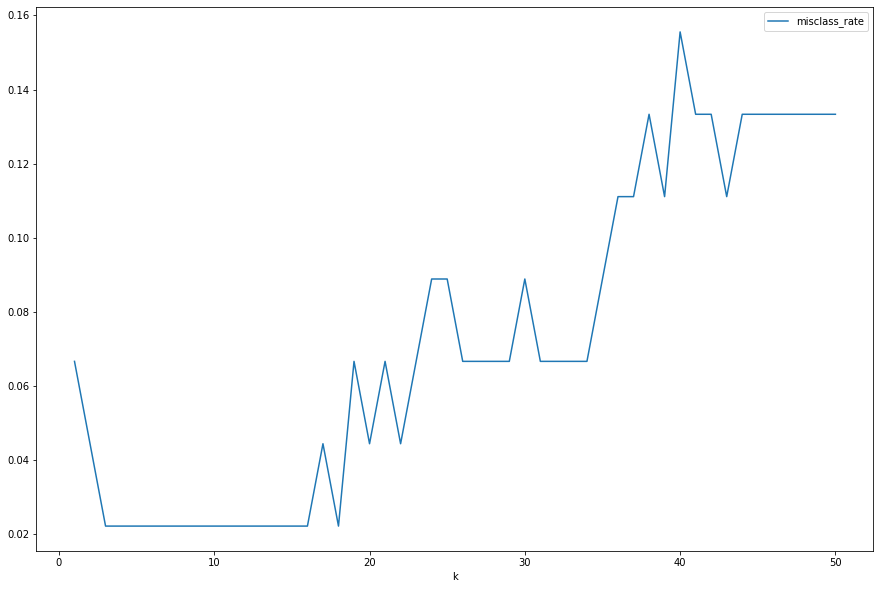

In [297]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))
result.plot(x='k', y='misclass_rate', ax=ax)

Our best misclassification rate was 0.222, for k values between 3 and 18.